## Actor Critic Policy Gradient
使用蒙特卡洛策略梯度(MTPG)方法使用了实际的奖励作为状态价值的估计，它虽然是无偏的，但是噪声却比较大，也就是**方差较高**。如果我们能够相对准确地估计状态价值，**使用预测的行为价值函数降低预测的方差**，用它来指导策略更新，那么是不是会有更好的学习效果呢？这就是Actor-Critic策略梯度的主要思想。**使用 Critic 估计状态行为价值**。
1. Critic: Value-based 参数化行为价值函数 $Q_w(s,a)$，策略评估过程，确定参数 $\theta$ 对应的策略 $\pi_{\theta}$ 的表现如何，代表的是策略估计的过程，可以使用之前的策略评估的方法得到解决(MC, TD, TD($\lambda$), DQN, LS , ....),REINFORCE中的 $Q(s,a)$函数是实际的折扣奖励
2. Actor: Policy-based 参数化的 $\pi_{\theta}$ 策略，按照 Critic 部分得到的价值引导策略函数参数 $\theta$ 的更新，策略改善过程


这样，Actor-Critic算法遵循的是一个近似的策略梯度
$$\nabla_{\theta}J(\theta)\approx \mathbb{E}_{\pi_{\theta}}[\nabla_{\theta}\log\pi_{\theta}(s,a)Q_w(s,a)]$$

之后的策略梯度的优化方法和之前的 REINFORCE 一致，知识 $Q(s,a)$ 的获得方式不同，REINFORCE是真实折扣累积奖励，Actor-Critic使用的是参数化的Critic价值网络

---
因为设计到了两个网络的联合训练，实际的效果和之前的方法相比有一些差距，并且训练不稳定，训练过长还会出现效果下降的问题，但是这是一个有前景的方向，目前针对这一个学习范式也提出了很多新的方法，效果也明显的超越了之前的DQN和简单的MCPG方法，比如DPG，DDPG，PPO等

In [1]:
import matplotlib.pyplot as plt
from IPython import display
from IPython.display import clear_output
from utils import *
import gym
import time
import pandas
import numpy as np
import ipdb
import pickle
from tqdm import tqdm
import tensorflow as tf
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
from brain.A2C import *
%matplotlib inline

In [2]:
env = gym.make('CartPole-v0')
env.seed(1)

[1]

In [3]:
# Superparameters
MAX_EPISODE = 600
MAX_EP_STEPS = 200   # maximum time step in one episode
RENDER = False       # rendering wastes time
GAMMA = 0.9          # reward discount in TD error
LR_A = 0.001         # learning rate for actor
LR_C = 0.005         # learning rate for critic, good teacher can teach student greatly

N_F = env.observation_space.shape[0]
N_A = env.action_space.n
N_F, N_A

(2, 3)

In [4]:
actor = Actor(sess, n_features=N_F, n_actions=N_A, lr=LR_A)
critic = Critic(sess, n_features=N_F, lr=LR_C)    
sess.run(tf.global_variables_initializer())
# we need a good teacher, so the teacher should learn faster than the actor

In [5]:
def try_one_episode(max_episode=200):
    observation = env.reset()
    for i in range(max_episode):
        env.render(mode='rgb_array')
        # observation = discretize(observation)
        show_state(env, i, None)
        action = actor.choose_action(observation)
        observation, reward, done, info = env.step(action)
        if done:
            break
    clear_output(wait=True)

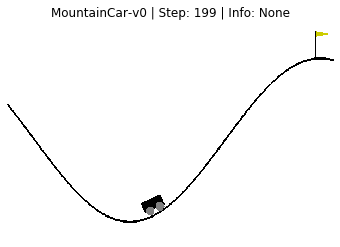

In [6]:
try_one_episode(max_episode=200)

In [6]:
final_rewards = []
running_reward = 0
pbar = tqdm(range(MAX_EPISODE))
for i_episode in pbar:
    s = env.reset()
    t = 0
    track_r = []
    while True:
        # Policy-based actor choose the action
        a = actor.choose_action(s)

        s_, r, done, info = env.step(a)
        track_r.append(r)
        
        # if done: 
        #     r = -20

        # Value-based critic learn the value function for each state
        td_error = critic.learn(s, r, s_)  # gradient = grad[r + gamma * V(s_) - V(s)]
        
        # Policy-based actor learn from the critic's predicted value
        actor.learn(s, a, td_error)     # true_gradient = grad[logPi(s,a) * td_error]

        s = s_
        t += 1

        if done or t >= MAX_EP_STEPS:
            break
    final_rewards.append(np.sum(track_r))
    running_reward = running_reward * 0.99 + 0.01 * np.sum(track_r)
    pbar.set_description(f'Running rewards: {round(running_reward, 4)}, Current rewards: {round(np.sum(track_r))}')

Running rewards: 36.9511, Current rewards: 45.0: 100%|██████████| 600/600 [07:44<00:00,  1.56it/s]


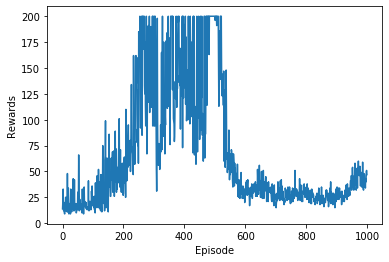

In [7]:
x = np.arange(len(final_rewards))
plt.plot(x, final_rewards)
plt.xlabel('Episode')
plt.ylabel('Rewards')
plt.savefig('./image/A2C-cartpole.png')

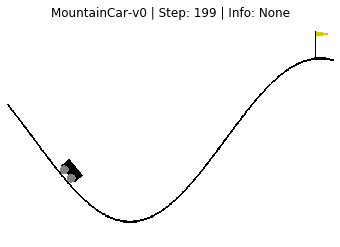

In [7]:
try_one_episode(max_episode=1000)    # 1000 for mauntaincar